# SVI Model Free Wings Review
url: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3557646 

## Preliminary Works
1. Black, Scholes, and Merton (1973)
2. Mathematical interpolation vs Financial interpolation models
3. Dupire (1994), Derman and kani (1994), and Rubinstein (1994): local volatility
4. Kahale (2004): surface interpolation - 1) interpolate arb-free call price, piecewise convex poly 2) interpolate linearly the total implied "variance", and 3) adjustments to ensure arb-free IVS
5. Gatheral (2004): SVI implied volatility method
6. Benko et al (2007): non-parametric smoothing
7. Fengler (2009): natural smoothing spline + constraintss
8. Huge (2010): implicit finite difference Euler scheme
9. Glaser and Heider (2012): locally constrained least squares approximations
10. Fingler-Hin (2013): semi-nonparametric based on a tensor-product B-spline
11. Gatheral & Jacquier (2014): SVI JW (Jump-Wing) parametric model, but no guarantee arb-free

## Local and Implied Volatility

## Lee's Moment Formula

In [ ]:
import numpy as np
from scipy.optimize import minimize

# SVI Model 함수 정의
def svi_model(k, params):
    a, b, rho, m, sigma = params
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# SVI 모델에 대한 목적 함수 (예: 오차 최소화)
def objective(params, k_data, w_data):
    # 계산된 SVI 값
    w_calc = svi_model(k_data, params)
    # 실제 데이터와의 차이 (최소화하려는 값)
    return np.sum((w_calc - w_data)**2)

# 제약조건 정의
def constraints(params):
    a, b, rho, m, sigma = params
    constraints_list = []

    # Parameters Boundaries
    constraints_list.append(a > 0)
    constraints_list.append(b > 0 and b < 1)
    constraints_list.append(rho > -1 and rho < 1)
    constraints_list.append(sigma > 0)
    
    # Butterfly arbitrage constraints
    constraints_list.append((a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) > 0)
    constraints_list.append((a - m * b * (rho - 1)) * (4 - a - m * b * (rho - 1)) > 0)
    constraints_list.append(0 < b**2 * (rho + 1)**2 < 4)
    constraints_list.append(0 < b**2 * (rho - 1)**2 < 4)
    
    return constraints_list

# 최적화 함수
def optimize_svi(k_data, w_data):
    # 초기 파라미터 추정값
    initial_guess = [0.5, 0.5, 0, 0, 0.5]  # a, b, rho, m, sigma
    
    # 제약조건 (boundary와 butterfly arbitrage)
    cons = ({'type': 'ineq', 'fun': lambda x: constraints(x)})

    # 최적화 문제 해결 (SQP 방식)
    result = minimize(objective, initial_guess, args=(k_data, w_data), method='trust-constr', constraints=cons)
    
    return result

# 예시 데이터 (k_data, w_data)
k_data = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900])  # k값 예시
w_data = np.array([0.9, 0.8, 0.75, 0.7, 0.65, 0.63, 0.6, 0.58, 0.55])  # 실제 w(k) 데이터

# 최적화 실행
result = optimize_svi(k_data, w_data)

# 결과 출력
print("최적화된 파라미터:", result.x)
print("최적화된 목적 함수 값:", result.fun)


In [4]:
import pandas as pd


,ticker,K,M,S,T,r,q,ask,bid,mid,...,gamma_mid,theta_mid,vega_mid,rho_mid,ival,true,ylast,days_ex,FF,x
0,SPX 5/16/25 C200,200,0.038773,5158.2,0.067742,0.045492,0.018461,4955.399902,4937.299805,4946.349854,...,NaN,NaN,NaN,NaN,4920.919922,4918.116024,5437.060059,24.725648,5167.653760,-3.251857
1,SPX 5/16/25 C400,400,0.077546,5158.2,0.067742,0.045492,0.018461,4755.800781,4736.699219,4746.250000,...,NaN,NaN,NaN,NaN,4720.919922,4718.710369,NaN,24.725648,5167.653760,-2.558709
2,SPX 5/16/25 C600,600,0.116320,5158.2,0.067742,0.045492,0.018461,4556.500000,4537.398438,4546.949219,...,NaN,NaN,NaN,NaN,4520.919922,4519.304715,4869.299805,24.725648,5167.653760,-2.153244
3,SPX 5/16/25 C800,800,0.155093,5158.2,0.067742,0.045492,0.018461,4356.500000,4338.398438,4347.449219,...,NaN,NaN,NaN,NaN,4320.919922,4319.899060,NaN,24.725648,5167.653760,-1.865562
4,SPX 5/16/25 C1000,1000,0.193866,5158.2,0.067742,0.045492,0.018461,4157.199219,4139.097656,4148.148438,...,NaN,NaN,NaN,NaN,4120.919922,4120.493406,4273.220215,24.725648,5167.653760,-1.642419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,SPX 5/16/25 C10000,10000,1.938661,5158.2,0.067742,0.045480,0.018461,0.300000,NaN,0.150000,...,0.000171,-0.070249,0.049938,0.000035,NaN,NaN,0.200000,24.725648,5167.649728,0.660167
495,SPX 5/16/25 C10400,10400,2.016208,5158.2,0.067742,0.045480,0.018461,0.300000,NaN,0.150000,...,0.000156,-0.070928,0.047875,0.000033,NaN,NaN,NaN,24.725648,5167.649728,0.699388
496,SPX 5/16/25 C10800,10800,2.093754,5158.2,0.067742,0.045480,0.018461,0.300000,NaN,0.150000,...,0.000143,-0.071519,0.046049,0.000032,NaN,NaN,0.210000,24.725648,5167.649728,0.737128
497,SPX 5/16/25 C10900,10900,2.113141,5158.2,0.067742,0.045480,0.018461,0.300000,NaN,0.150000,...,0.000140,-0.071711,0.045671,0.000032,NaN,NaN,NaN,24.725648,5167.649728,0.746345


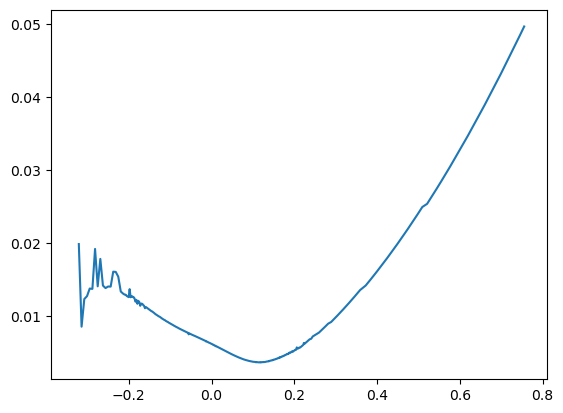

In [38]:
from OptionPricer import BlackScholes
import pandas as pd
import matplotlib.pyplot as plt
call_df = pd.read_csv('../data/cleaned_data/Bloomberg/spx_call_051625_1634.csv')
bs = BlackScholes(call_df)
call_df['my_iv_mid'] = bs.find_imvol_call('mid')
call_df['w'] = call_df['my_iv_mid'] ** 2 * call_df['T']
plt.plot(call_df['x'], call_df['w'])
plt.show()
# df['my_iv_mid'] = BlackScholes

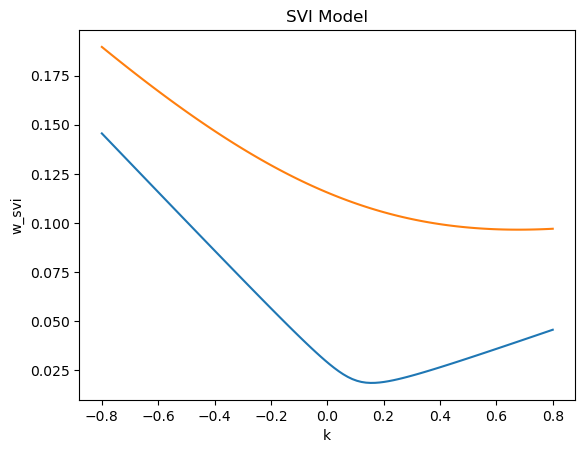

In [36]:
a = 0.01
b = 0.1
rho = -0.5
m = 0.1
sigma = 0.1
k = np.linspace(-0.8, 0.8, 100) 
for sigma in [0.1, 1]:
    w_svi = a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

    plt.plot(k, w_svi, label=f'{a}')
    plt.xlabel('k')
    plt.ylabel('w_svi')
    plt.title('SVI Model')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


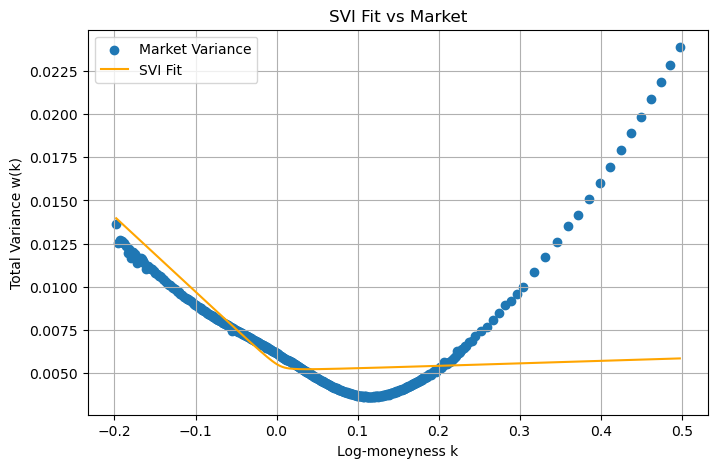

{'a': 0.005114485062764645, 'b': 0.022549196751255263, 'rho': -0.9350739713394854, 'm': 0.004806865049337859, 'sigma': 0.012381906385510682}


In [122]:
import numpy as np
from scipy.optimize import minimize
from itertools import product
import matplotlib.pyplot as plt

class SVI:
    def __init__(self, k, w_market, t, init_guess=None):
        self.k = k
        self.w_market = w_market
        self.t = t
        self.bounds = [
            (1e-5, np.max(w_market)),       # a
            (1e-3, 1),                      # b
            (-0.95, 0.95),                 # rho (expanded)
            (np.min(k) - 0.1, np.max(k) + 0.1), # m (expanded)
            (0.01, 1)                       # sigma
        ]
        self.result = None
        self.grid = [
            np.linspace(lower, upper, 5) for (lower, upper) in self.bounds
        ]
        if init_guess is None:
            self.init_guess = (0.000343, 0.023149, 0.9, 0.02053, 0.05065)
        else:
            self.init_guess = init_guess
        self.a, self.b, self.rho, self.m, self.sigma = self.init_guess

    def _raw_svi(self, k, a, b, rho, m, sigma):
        return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

    def objective(self, params):
        w_model = self._raw_svi(self.k, *params)
        return np.mean((w_model - self.w_market)**2)

    def butterfly_constraints(self, params):
        a, b, rho, m, sigma = params
        epsilon = 1e-6
        cond1 = (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2
        cond2 = (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2
        cond3 = 4 - b**2 * (rho + 1)**2
        cond4 = 4 - b**2 * (rho - 1)**2
        return [cond1 - epsilon, cond2 - epsilon, cond3 - epsilon, cond4 - epsilon]

    def fit(self, grid_search=True):
        constraints = [
            {
                'type': 'ineq',
                'fun': lambda x, i=i: self.butterfly_constraints(x)[i]
            } for i in range(4)
        ]

        best_result = None
        best_params = None
        best_mse = float("inf")

        candidates = list(product(*self.grid))
        if grid_search:
            candidates.append(tuple(self.init_guess))
        else:
            candidates = [tuple(self.init_guess)]

        for guess in candidates:
            # 사전 제약 조건 검사
            if not all(c >= 0 for c in self.butterfly_constraints(guess)):
                continue

            result = minimize(self.objective,
                              guess,
                              method='SLSQP',
                              bounds=self.bounds,
                              constraints=constraints)

            if result.success:
                a, b, rho, m, sigma = result.x
                self.a, self.b, self.rho, self.m, self.sigma = a, b, rho, m, sigma
                svi_w = self.svi_curve["svi_w"]
                mse = np.mean((np.array(svi_w) - self.w_market) ** 2)
                if mse < best_mse:
                    best_mse = mse
                    best_result = result
                    best_params = [a, b, rho, m, sigma]

        if best_result is not None:
            self.result = best_result
            self.a, self.b, self.rho, self.m, self.sigma = best_params
        else:
            print("All optimizations failed or constraints violated.")

    def svi_w(self, k):
        return self._raw_svi(k, self.a, self.b, self.rho, self.m, self.sigma)

    @property
    def svi_curve(self):
        return {
            "k": self.k,
            "svi_w": [self.svi_w(k) for k in self.k]
        }

    @property
    def fit_result(self):
        return self.result

    @property
    def params(self):
        return {
            "a": self.a, "b": self.b, "rho": self.rho, "m": self.m, "sigma": self.sigma
        }

    def jw_paramas(self):
        nu = (self.a + self.b * (-self.rho * self.m + np.sqrt(self.m ** 2 + self.sigma ** 2))) / self.t
        psi = (1 / np.sqrt(nu * self.t)) * (self.b / 2) * (-self.m / (np.sqrt(self.m**2 + self.sigma**2)) + self.rho)
        p = (1 / np.sqrt(nu * self.t)) * self.b * (1 - self.rho)
        c = (1 / np.sqrt(nu * self.t)) * self.b * (1 + self.rho)
        nu_tilde = (1 / self.t) * (self.a + self.b * self.sigma * np.sqrt(1 - self.rho ** 2))
        return {
            "nu": nu, "psi": psi, "p": p, "c": c, "nu_tilde": nu_tilde
        }

    def plot_fit(self):
        plt.figure(figsize=(8, 5))
        plt.scatter(self.k, self.w_market, label="Market Variance")
        plt.plot(self.k, self.svi_curve["svi_w"], color="orange", label="SVI Fit")
        plt.title("SVI Fit vs Market")
        plt.xlabel("Log-moneyness k")
        plt.ylabel("Total Variance w(k)")
        plt.legend()
        plt.grid(True)
        plt.show()
        
df = call_df[(call_df['x'] < 0.5) & (call_df['x'] > -0.2)].loc[:, ["x", "w"]].dropna()
k = df['x'].values
w = df['w'].values
t = call_df['T'].unique()[0]
svi = SVI(k, w, t)
svi.fit(grid_search=True)
svi.plot_fit()
print(svi.params)

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


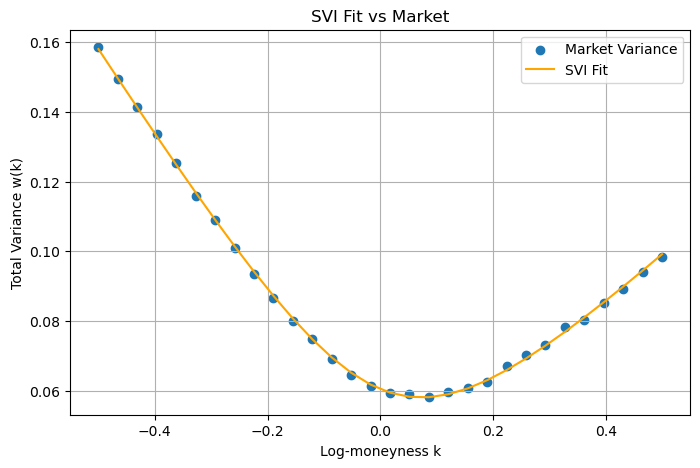

In [123]:
k = np.linspace(-0.5, 0.5, 30)
true_params = (0.02, 0.2, -0.3, 0.0, 0.2)
a, b, rho, m, sigma = true_params
w_market = a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# Add small noise
np.random.seed(0)
w_market += np.random.normal(0, 0.0005, size=w_market.shape)

# Time to maturity
T = 0.5

# Fit using SVI class
svi = SVI(k, w_market, T)
svi.fit(grid_search=True)
svi.plot_fit()

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.00047634541472881155
       x: [ 3.241e-03  3.101e-02  2.270e-02  9.427e-02  1.000e-02]
     nit: 19
     jac: [ 1.510e-01 -1.919e-02 -4.367e-04 -5.613e-03  8.615e-04]
    nfev: 115
    njev: 19


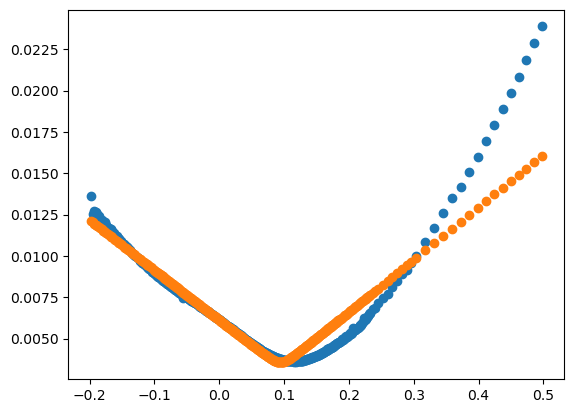

In [113]:
import numpy as np
from scipy.optimize import minimize

class SVI:
    def __init__(self, k, w_market, t, init_guess = None):
        self.k = k                          # log-moneyness
        self.w_market = w_market            # total implied variance (sigma^2 * T)
        self.bounds = [
            (1e-5, np.max(w_market)),       # a
            (1e-3, 1),                      # b
            (-1 + 1e-6, 1 - 1e-6),          # rho
            (2 * np.min(k), 2 * np.max(k)), # m
            (0.01, 1)                       # sigma
        ]
        self.result = None
        if init_guess is None:
           self.init_guess = [0.5 * np.min(w_market), 0.1, -0.5, 0.1, 0.1]
        self.a,  self.b, self.rho, self.m, self.sigma = self.init_guess

    # def _raw_svi(self, k, a, b, rho, m, sigma):
    #     return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

    def objective(self, params):
        a, b, rho, m, sigma = params
        w_model = a + b * (rho * (self.k - m) + np.sqrt((self.k - m)**2 + sigma**2))
        # w_model = self._raw_svi(self.k, a, b, rho, m, sigma)
        return np.sum((w_model - self.w_market)**2)

    def butterfly_constraints(self, params):
        a, b, rho, m, sigma = params
        epsilon = 1e-6
        cond1 = (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2
        cond2 = (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2
        cond3 = 4 - b**2 * (rho + 1)**2
        cond4 = 4 - b**2 * (rho - 1)**2
        return [cond1 - epsilon, cond2 - epsilon, cond3 - epsilon, cond4 - epsilon]

    def fit(self):
        constraints = [
            {
                'type': 'ineq',
                'fun': lambda x, i=i: self.butterfly_constraints(x)[i] # closure issue
            } for i in range(4)
        ]

        result = minimize(self.objective, 
                          self.init_guess,
                          method='SLSQP',
                          bounds=self.bounds,
                          constraints=constraints)

        if result.success:
            self.result = result
            self.a, self.b, self.rho, self.m, self.sigma = result.x
        else:
            print("Optimization failed")
            print()
            
    def svi_w(self, k):
        return self.a + self.b * (self.rho * (k - self.m) + np.sqrt((k - self.m)**2 + self.sigma**2))
    
    @property
    def svi_curve(self):
        curve = {"k": self.k, "svi_w": []}
        for k in self.k:
            curve["svi_w"].append(self.svi_w(k))
        return curve
    
    @property
    def fit_result(self):
        return self.result
    
    @property
    def params(self):
        return {
            "a": self.a, "b": self.b, "rho": self.rho, "m": self.m, "sigma": self.sigma
        }
    
    @staticmethod
    def jw_paramas(self):
        nu = (self.a + self.b * (-self.rho * self.m + np.sqrt(self.m ** 2 + self.sigma ** 2))) / self.t # ATM variance
        psi = (1/np.sqrt(nu * self.t)) * (self.b/2) * (-self.m/(np.sqrt(self.m**2 + self.sigma**2)) + self.rho) # ATM skew
        p = (1/np.sqrt(nu * self.t)) * self.b * (1 - self.rho) # slope of left (put) wing
        c = (1/np.sqrt(nu * self.t)) * self.b * (1 + self.rho) # slope of right (call) wing
        nu_tilde = (1/self.t) * (self.a + self.b * self.sigma * np.sqrt(1 - self.rho **2))
        return {
            "nu": nu, "psi": psi, "p": p, "c": c, "nu_tilde": nu_tilde
        }
    

# Dummy example to test
k = np.linspace(-1, 1, 40)
w_market = 0.2 + 0.05 * k**2

df = call_df[(call_df['x'] < 0.5) & (call_df['x'] > -0.2)].loc[:, ["x", "w"]].dropna()
k = df['x'].values
w = df['w'].values
t = call_df['T'].unique()[0]

svi = SVI(k, w, t)
svi.fit()
print(svi.fit_result)
svi_w = svi.svi_curve['svi_w']
plt.scatter(k, w)
plt.scatter(k, svi_w)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.5646047271725467e-05
       x: [ 3.073e-03  2.671e-02 -2.105e-02  1.110e-01  1.394e-02]
     nit: 28
     jac: [ 6.160e-03 -1.608e-03 -2.659e-05 -2.398e-04 -3.571e-05]
    nfev: 173
    njev: 28


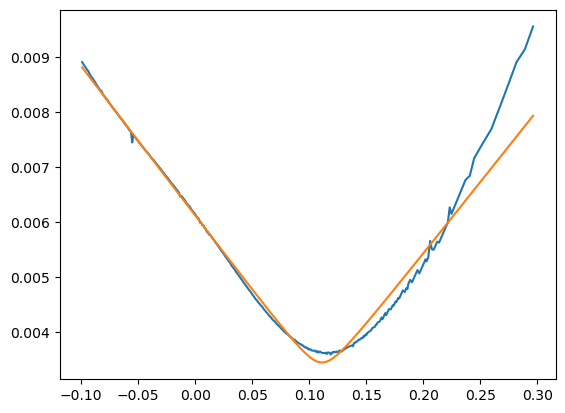

In [154]:
# Re-import necessary libraries and redefine the SVI class after kernel reset
import numpy as np
from scipy.optimize import minimize
from itertools import product

class SVI:
    def __init__(self, k, w_market, t, weight, init_guess=None):
        self.k = k
        self.w_market = w_market
        self.t = t
        self.bounds = [
            (1e-5, np.max(w_market)),       # a
            (1e-3, 1),                      # b
            (-1 + 1e-6, 1 - 1e-6),          # rho
            (2 * np.min(k), 2 * np.max(k)), # m
            (0.01, 1)                       # sigma
        ]
        self.result = None
        self.grid = [
            np.linspace(lower, upper, 3) for (lower, upper) in self.bounds
        ]
        if init_guess is None:
            self.init_guess = (0.000343, 0.023149, 0.9, 0.02053, 0.05065)
        else:
            self.init_guess = init_guess
        self.a, self.b, self.rho, self.m, self.sigma = self.init_guess

    # def _raw_svi(self, k, a, b, rho, m, sigma):
    #     return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

    def objective(self, params):
        a, b, rho, m, sigma = params
        w_model = a + b * (rho * (self.k - m) + np.sqrt((self.k - m)**2 + sigma**2))
        # w_model = self._raw_svi(self.k, a, b, rho, m, sigma)
        return np.sum((w_model - self.w_market)**2)

    def butterfly_constraints(self, params):
        a, b, rho, m, sigma = params
        epsilon = 1e-6
        cond1 = (a - m * b * (rho + 1)) * (4 - a + m * b * (rho + 1)) - b**2 * (rho + 1)**2
        cond2 = (a - m * b * (rho - 1)) * (4 - a + m * b * (rho - 1)) - b**2 * (rho - 1)**2
        cond3 = 4 - b**2 * (rho + 1)**2
        cond4 = 4 - b**2 * (rho - 1)**2
        return [cond1 - epsilon, cond2 - epsilon, cond3 - epsilon, cond4 - epsilon]

    def fit(self, grid_search=True):
        constraints = [
            {
                'type': 'ineq',
                'fun': lambda x, i=i: self.butterfly_constraints(x)[i]
            } for i in range(4)
        ]

        best_result = None
        best_params = None
        best_mse = float("inf")

        candidates = list(product(*self.grid))
        if grid_search:
            candidates.append(self.init_guess)
        else:
            candidates = [self.init_guess]
        
        # Grid Search
        for guess in candidates:
            result = minimize(self.objective,
                              guess,
                              method='SLSQP',
                              bounds=self.bounds,
                              constraints=constraints)
            if result.success:
                a, b, rho, m, sigma = result.x
                self.a, self.b, self.rho, self.m, self.sigma = a, b, rho, m, sigma
                svi_w = self.svi_curve["svi_w"]
                mse = np.mean((np.array(svi_w) - self.w_market) ** 2)
                if mse < best_mse:
                    best_mse = mse
                    best_result = result
                    best_params = [a, b, rho, m, sigma]

        if best_result is not None:
            self.result = best_result
            self.a, self.b, self.rho, self.m, self.sigma = best_params
        else:
            print("All optimizations failed or constraints violated.")

    def svi_w(self, k):
        return self.a + self.b * (self.rho * (k - self.m) + np.sqrt((k - self.m)**2 + self.sigma**2))

    @property
    def svi_curve(self):
        return {
            "k": self.k,
            "svi_w": [self.svi_w(k) for k in self.k]
        }

    @property
    def fit_result(self):
        return self.result

    @property
    def params(self):
        return {
            "a": self.a, "b": self.b, "rho": self.rho, "m": self.m, "sigma": self.sigma
        }

    def jw_paramas(self):
        nu = (self.a + self.b * (-self.rho * self.m + np.sqrt(self.m ** 2 + self.sigma ** 2))) / self.t
        psi = (1 / np.sqrt(nu * self.t)) * (self.b / 2) * (-self.m / (np.sqrt(self.m**2 + self.sigma**2)) + self.rho)
        p = (1 / np.sqrt(nu * self.t)) * self.b * (1 - self.rho)
        c = (1 / np.sqrt(nu * self.t)) * self.b * (1 + self.rho)
        nu_tilde = (1 / self.t) * (self.a + self.b * self.sigma * np.sqrt(1 - self.rho ** 2))
        return {
            "nu": nu, "psi": psi, "p": p, "c": c, "nu_tilde": nu_tilde
        }

df = call_df[(call_df['x'] < 0.3) & (call_df['x'] > -0.1)].loc[:, ["x", "w"]].dropna()
k = df['x'].values
w = df['w'].values
t = call_df['T'].unique()[0]

svi = SVI(k, w, t)
svi.fit()
print(svi.fit_result)
svi_w = svi.svi_curve['svi_w']
plt.plot(k, w)
plt.plot(k, svi_w)
plt.show()

In [141]:
svi.params

{'a': 0.0030729924748602593,
 'b': 0.026714031341908355,
 'rho': -0.02104871526464559,
 'm': 0.11095749581762877,
 'sigma': 0.013942343488765649}

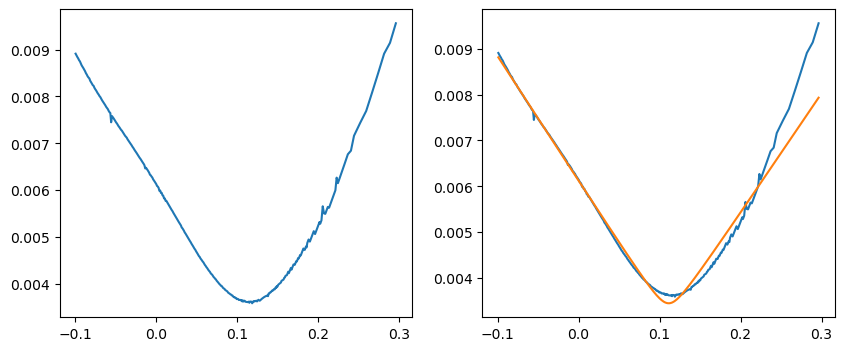

In [144]:
k = df['x'].values
w = df['w'].values
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(k, w, label='market')
axes[1].plot(k, w, label='market')
axes[1].plot(k, svi.svi_curve['svi_w'])
plt.show()

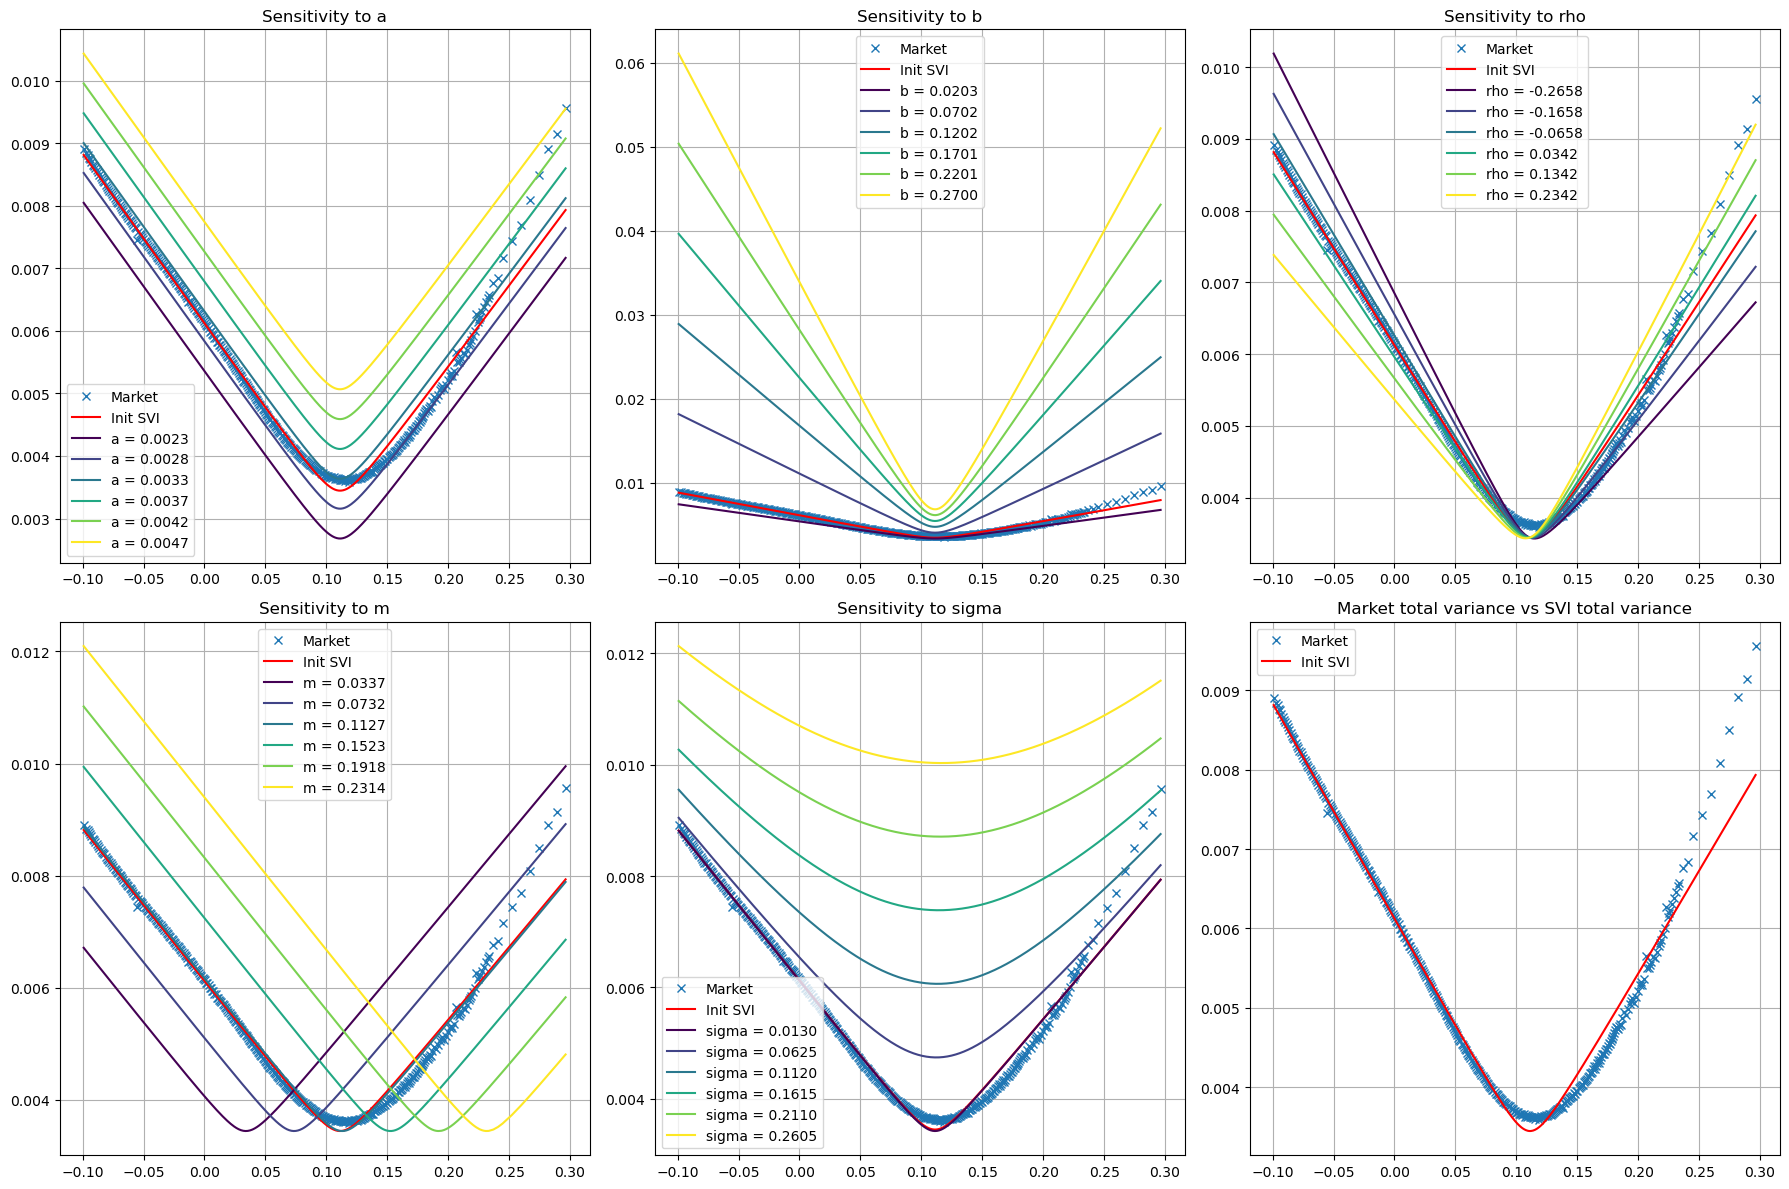

In [172]:
import matplotlib.pyplot as plt
import numpy as np

def svi_curve(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

k = df['x'].values
w = df['w'].values
names = ['a', 'b', 'rho', 'm', 'sigma']
a, b, rho, m, sigma = list(svi.params.values())
svi_w_init = svi_curve(k, a, b, rho, m, sigma)
bounds = svi.bounds
init_params = list(svi.params.values())

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

colors = plt.cm.viridis(np.linspace(0, 1, 6))  # 6가지 색상

for i in range(5):    
    ax = axes[i]
    ax.plot(k, w, 'x', label='Market')  # 시장 w
    ax.plot(k, svi_w_init, color='red', label='Init SVI')
    
    low, high = bounds[i]
    mid = init_params[i]

    # bound 안에서 변화 주기
    test_vals = np.linspace(
        0.75 * mid + 0.25 * low,
        0.75 * mid + 0.25 * high,
        6
    )

    for j, test_val in enumerate(test_vals):
        params = init_params.copy()
        params[i] = test_val
        a_, b_, rho_, m_, sigma_ = params
        svi_w = svi_curve(k, a_, b_, rho_, m_, sigma_)
        ax.plot(k, svi_w, color=colors[j], label=f"{names[i]} = {test_val:.4f}")

    ax.set_title(f"Sensitivity to {names[i]}")
    ax.grid(True)
    ax.legend(fontsize=10)

# 마지막 빈 subplot 숨기기
axes[-1].plot(k, w, 'x', label='Market')
axes[-1].plot(k, svi_w_init, color='red', label='Init SVI')
axes[-1].set_title(f"Market total variance vs SVI total variance")
axes[-1].grid(True)
axes[-1].legend(fontsize=10)

plt.tight_layout()
plt.savefig("SVI_first_implementation.png", dpi=300)
plt.show()